# Gravity Guy ML Baseline Analysis

This notebook analyzes the performance of different baseline agents for the Gravity Guy reinforcement learning environment. We compare a random policy against several heuristic approaches to establish performance benchmarks before implementing machine learning strategies.

## Environment Overview

The Gravity Guy environment is a 2D platformer where:
- The player automatically scrolls right at constant speed
- Platforms exist on top and bottom lanes
- The player can flip gravity to switch between lanes
- Goal: Survive as long as possible by avoiding going out of bounds
- Reward: Distance traveled minus small penalty for gravity flips

**Observation Space (6D vector):**
- `y_norm`: Normalized vertical position [0,1]
- `vy_norm`: Normalized vertical velocity [-1,1] 
- `grav_dir`: Gravity direction (+1 down, -1 up)
- `probe1`, `probe2`, `probe3`: Clearance sensors at 60px, 180px, 300px ahead [0,1]

**Action Space:** Discrete (0=wait, 1=attempt gravity flip)

## Loading and Preprocessing Data

In [27]:
import json
import glob
import statistics as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_latest_runs(tag: str):
    """Load the most recent run data for a given policy tag"""
    paths = sorted(glob.glob(f"../runs/*_{tag}.jsonl"))
    if not paths:
        print(f"No runs found for tag={tag}")
        return []
    
    path = paths[-1]  # Most recent
    print(f"Loading {tag}: {path}")
    
    episodes = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            episodes.append(json.loads(line.strip()))
    
    return episodes

# Load all baseline agent results
random_data = load_latest_runs("random")
heuristic_data = load_latest_runs("heuristic") 
improved_data = load_latest_runs("improved")
conservative_data = load_latest_runs("conservative")
aggressive_data = load_latest_runs("aggressive")

print(f"\nDatasets loaded:")
print(f"Random: {len(random_data)} episodes")
print(f"Heuristic: {len(heuristic_data)} episodes") 
print(f"Improved: {len(improved_data)} episodes")
print(f"Conservative: {len(conservative_data)} episodes")
print(f"Aggressive: {len(aggressive_data)} episodes")

Loading random: ../runs\1757364698_random.jsonl
Loading heuristic: ../runs\1757364699_heuristic.jsonl
Loading improved: ../runs\1757364699_improved.jsonl
Loading conservative: ../runs\1757364699_conservative.jsonl
Loading aggressive: ../runs\1757364699_aggressive.jsonl

Datasets loaded:
Random: 8 episodes
Heuristic: 8 episodes
Improved: 8 episodes
Conservative: 8 episodes
Aggressive: 8 episodes


## Performance Analysis

### Summary Statistics

In [28]:
def calculate_stats(episodes, policy_name):
    """Calculate comprehensive performance statistics"""
    if not episodes:
        return None
        
    distances = [e["distance_px"] for e in episodes]
    returns = [e["total_return"] for e in episodes] 
    flips = [e["flips"] for e in episodes]
    times = [e["time_s"] for e in episodes]
    
    # Termination analysis
    out_of_bounds = sum(1 for e in episodes if e.get("out_of_bounds", False))
    time_ups = sum(1 for e in episodes if e.get("time_up", False))
    
    return {
        "Policy": policy_name,
        "Episodes": len(episodes),
        "Avg Distance": np.mean(distances),
        "Std Distance": np.std(distances),
        "Max Distance": np.max(distances), 
        "Min Distance": np.min(distances),
        "Avg Return": np.mean(returns),
        "Avg Flips": np.mean(flips),
        "Avg Time": np.mean(times),
        "Success Rate": time_ups / len(episodes),  # Reached time limit
        "Death Rate": out_of_bounds / len(episodes),  # Went out of bounds
        "Efficiency": np.mean(distances) / np.mean(flips) if np.mean(flips) > 0 else np.inf
    }

# Calculate statistics for all policies
policies_data = [
    (random_data, "Random"),
    (heuristic_data, "Heuristic"), 
    (improved_data, "Improved"),
    (conservative_data, "Conservative"),
    (aggressive_data, "Aggressive")
]

results = []
for data, name in policies_data:
    stats = calculate_stats(data, name)
    if stats:
        results.append(stats)

# Create comparison DataFrame
df = pd.DataFrame(results)
df = df.round(2)

# Display results table
print("=== BASELINE AGENT COMPARISON ===")
print(df.to_string(index=False))

# Calculate improvements over random baseline
if len(results) > 0:
    baseline_distance = df[df["Policy"] == "Random"]["Avg Distance"].iloc[0]
    df["Distance Improvement (%)"] = ((df["Avg Distance"] - baseline_distance) / baseline_distance * 100).round(1)
    
    print(f"\n=== IMPROVEMENT OVER RANDOM BASELINE ===")
    improvement_df = df[["Policy", "Avg Distance", "Distance Improvement (%)", "Avg Flips"]].copy()
    print(improvement_df.to_string(index=False))

=== BASELINE AGENT COMPARISON ===
      Policy  Episodes  Avg Distance  Std Distance  Max Distance  Min Distance  Avg Return  Avg Flips  Avg Time  Success Rate  Death Rate  Efficiency
      Random         8       1623.00         48.03          1716          1554     1603.34       9.75      6.49           0.0         1.0      166.46
   Heuristic         8       2041.62        847.80          4191          1556     2021.91       1.38      8.17           0.0         1.0     1484.82
    Improved         8       2039.00        379.05          2685          1545     2019.56       2.00      8.16           0.0         1.0     1019.50
Conservative         8       1732.38        241.84          2210          1556     1712.80       1.62      6.93           0.0         1.0     1066.08
  Aggressive         8       1920.38        434.56          2868          1529     1900.81       2.25      7.68           0.0         1.0      853.50

=== IMPROVEMENT OVER RANDOM BASELINE ===
      Policy  Avg Distan

### Performance Visualization


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_27268\3139095455.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax1.boxplot(distances_by_policy, labels=labels, patch_artist=True)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_27268\3139095455.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  time_box_plot = ax4.boxplot(episode_times, labels=time_labels, patch_artist=True)


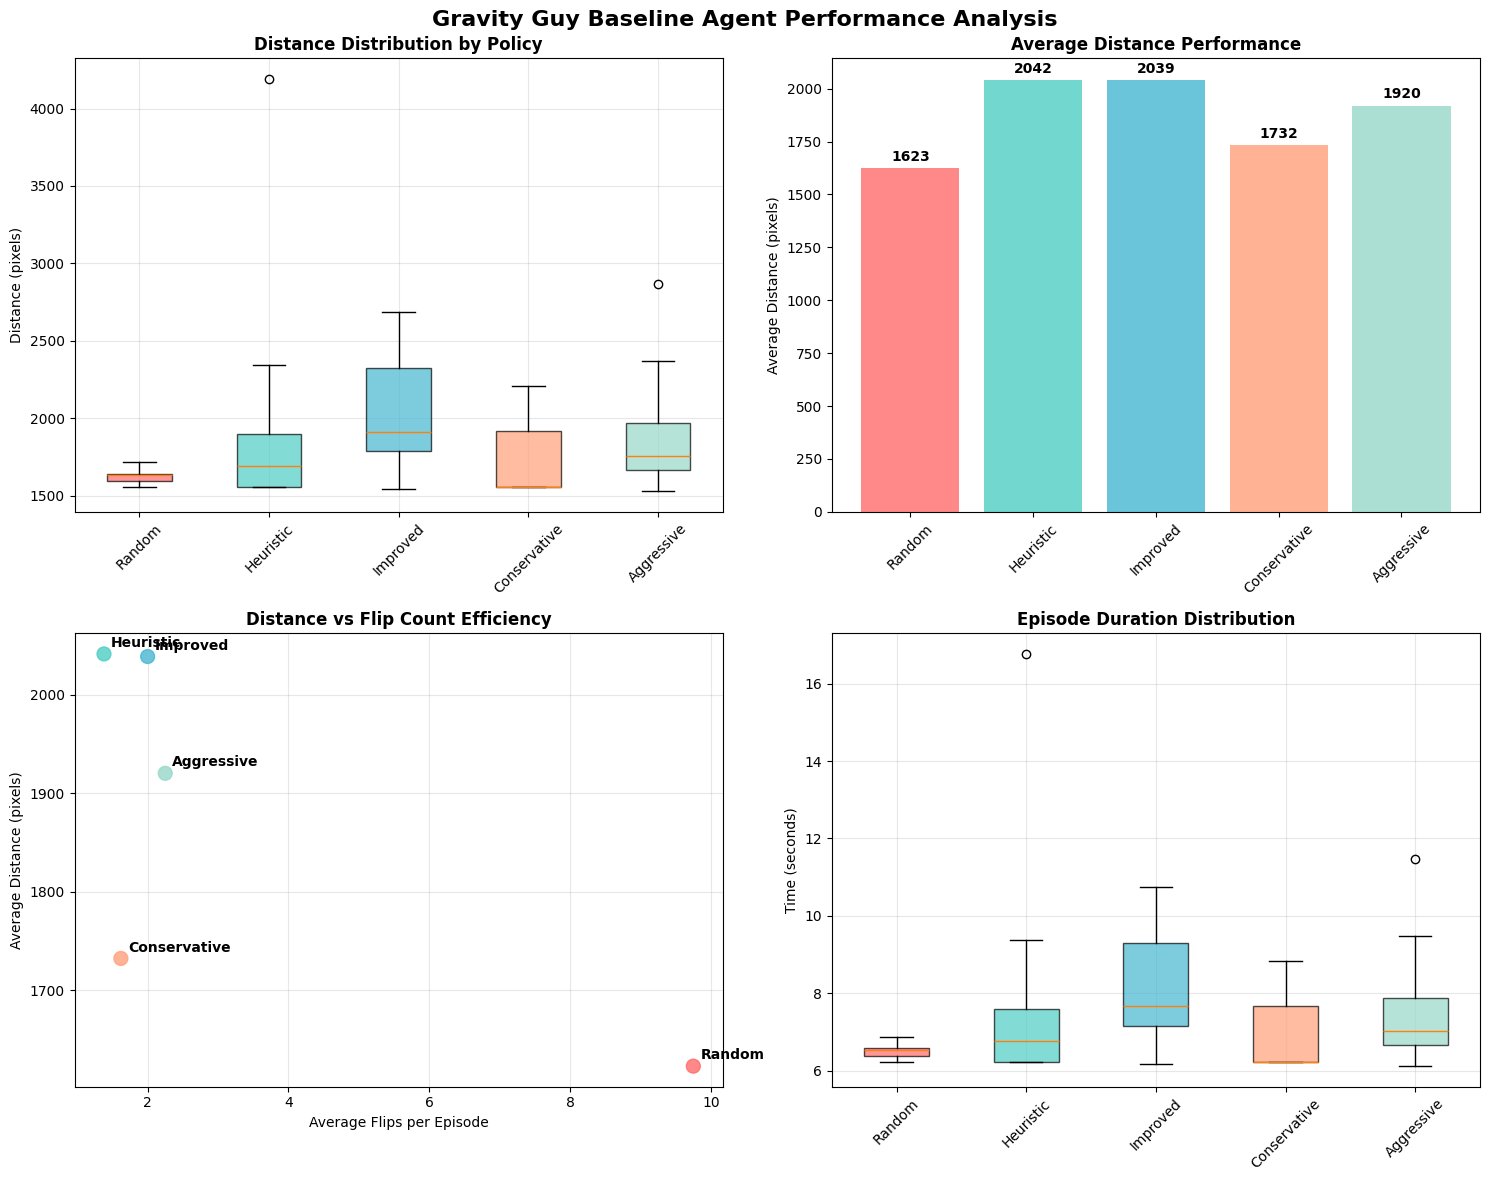

In [29]:
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Gravity Guy Baseline Agent Performance Analysis', fontsize=16, fontweight='bold')

# Extract data for plotting
policies = [name for _, name in policies_data if len([d for d, n in policies_data if n == name][0]) > 0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# 1. Distance Performance Comparison
ax1 = axes[0, 0]
distances_by_policy = []
labels = []

for i, (data, name) in enumerate(policies_data):
    if data:
        distances = [e["distance_px"] for e in data]
        distances_by_policy.append(distances)
        labels.append(name)

box_plot = ax1.boxplot(distances_by_policy, labels=labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors[:len(labels)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_title('Distance Distribution by Policy', fontweight='bold')
ax1.set_ylabel('Distance (pixels)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Average Performance Bar Chart
ax2 = axes[0, 1]
if results:
    policies_names = df["Policy"].tolist()
    avg_distances = df["Avg Distance"].tolist()
    
    bars = ax2.bar(policies_names, avg_distances, color=colors[:len(policies_names)], alpha=0.8)
    ax2.set_title('Average Distance Performance', fontweight='bold')
    ax2.set_ylabel('Average Distance (pixels)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, avg_distances):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Flip Efficiency Analysis
ax3 = axes[1, 0]
if results:
    avg_flips = df["Avg Flips"].tolist()
    scatter = ax3.scatter(avg_flips, avg_distances, 
                         c=colors[:len(policies_names)], s=100, alpha=0.8)
    
    for i, policy in enumerate(policies_names):
        ax3.annotate(policy, (avg_flips[i], avg_distances[i]), 
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    ax3.set_title('Distance vs Flip Count Efficiency', fontweight='bold')
    ax3.set_xlabel('Average Flips per Episode')
    ax3.set_ylabel('Average Distance (pixels)')
    ax3.grid(True, alpha=0.3)

# 4. Episode Length Distribution
ax4 = axes[1, 1]
episode_times = []
time_labels = []

for data, name in policies_data:
    if data:
        times = [e["time_s"] for e in data]
        episode_times.append(times)
        time_labels.append(name)

if episode_times:
    time_box_plot = ax4.boxplot(episode_times, labels=time_labels, patch_artist=True)
    for patch, color in zip(time_box_plot['boxes'], colors[:len(time_labels)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax4.set_title('Episode Duration Distribution', fontweight='bold')
ax4.set_ylabel('Time (seconds)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Detailed Episode Analysis

In [30]:
# Analyze individual episodes to understand behavior patterns
def analyze_episode_patterns():
    print("=== EPISODE PATTERN ANALYSIS ===\n")
    
    for data, name in policies_data:
        if not data:
            continue
            
        print(f"--- {name.upper()} POLICY ---")
        
        # Success vs failure analysis
        successes = [e for e in data if e.get("time_up", False)]  # Hit time limit
        failures = [e for e in data if e.get("out_of_bounds", False)]  # Died
        
        print(f"Episodes: {len(data)}")
        print(f"Successes (time limit): {len(successes)}")
        print(f"Failures (out of bounds): {len(failures)}")
        
        if successes:
            success_dist = [e["distance_px"] for e in successes]
            print(f"Success distances: {success_dist}")
        
        if failures:
            failure_dist = [e["distance_px"] for e in failures]
            failure_time = [e["time_s"] for e in failures]
            print(f"Failure distances: mean={np.mean(failure_dist):.0f}px, range={min(failure_dist)}-{max(failure_dist)}px")
            print(f"Failure times: mean={np.mean(failure_time):.1f}s, range={min(failure_time):.1f}-{max(failure_time):.1f}s")
        
        # Flip behavior analysis
        flips = [e["flips"] for e in data]
        distances = [e["distance_px"] for e in data]
        flip_efficiency = [d/f if f > 0 else d for d, f in zip(distances, flips)]
        
        print(f"Flip efficiency: {np.mean(flip_efficiency):.0f} pixels/flip")
        print(f"Flip variance: std={np.std(flips):.1f}")
        
        # Probe analysis (obstacle detection)
        final_probes = [e.get("probes", [1.0, 1.0, 1.0]) for e in data]
        if final_probes and len(final_probes[0]) == 3:
            avg_p1 = np.mean([p[0] for p in final_probes])
            avg_p2 = np.mean([p[1] for p in final_probes])  
            avg_p3 = np.mean([p[2] for p in final_probes])
            print(f"Final probe clearances: [{avg_p1:.2f}, {avg_p2:.2f}, {avg_p3:.2f}]")
        
        print()

analyze_episode_patterns()

=== EPISODE PATTERN ANALYSIS ===

--- RANDOM POLICY ---
Episodes: 8
Successes (time limit): 0
Failures (out of bounds): 8
Failure distances: mean=1623px, range=1554-1716px
Failure times: mean=6.5s, range=6.2-6.9s
Flip efficiency: 167 pixels/flip
Flip variance: std=0.8
Final probe clearances: [1.00, 1.00, 1.00]

--- HEURISTIC POLICY ---
Episodes: 8
Successes (time limit): 0
Failures (out of bounds): 8
Failure distances: mean=2042px, range=1556-4191px
Failure times: mean=8.2s, range=6.2-16.8s
Flip efficiency: 1750 pixels/flip
Flip variance: std=0.5
Final probe clearances: [1.00, 1.00, 1.00]

--- IMPROVED POLICY ---
Episodes: 8
Successes (time limit): 0
Failures (out of bounds): 8
Failure distances: mean=2039px, range=1545-2685px
Failure times: mean=8.2s, range=6.2-10.7s
Flip efficiency: 1673 pixels/flip
Flip variance: std=1.7
Final probe clearances: [1.00, 1.00, 1.00]

--- CONSERVATIVE POLICY ---
Episodes: 8
Successes (time limit): 0
Failures (out of bounds): 8
Failure distances: mean=17

### Learning Curve Visualization

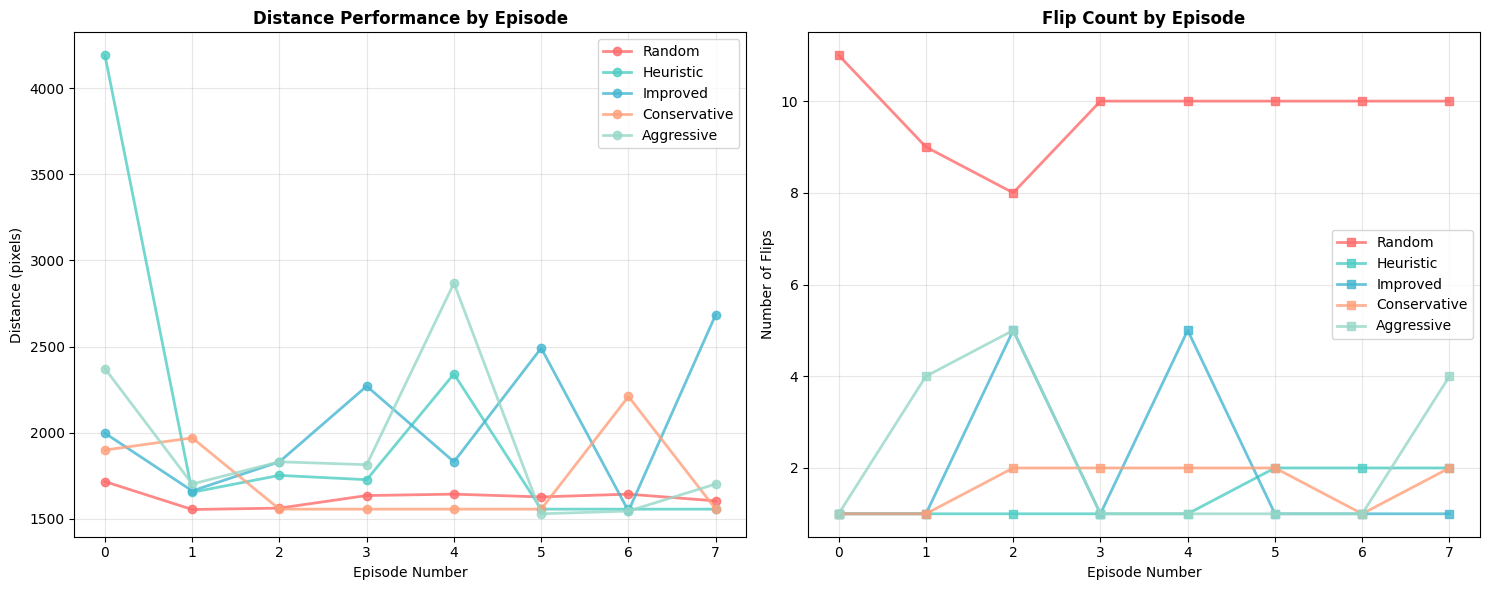

In [31]:
# Plot episode-by-episode performance to see consistency
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distance progression
for i, (data, name) in enumerate(policies_data):
    if data:
        episodes = range(len(data))
        distances = [e["distance_px"] for e in data]
        ax1.plot(episodes, distances, 'o-', label=name, color=colors[i], alpha=0.8, linewidth=2)

ax1.set_title('Distance Performance by Episode', fontweight='bold')
ax1.set_xlabel('Episode Number')
ax1.set_ylabel('Distance (pixels)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Flip count progression
for i, (data, name) in enumerate(policies_data):
    if data:
        episodes = range(len(data))
        flips = [e["flips"] for e in data]
        ax2.plot(episodes, flips, 's-', label=name, color=colors[i], alpha=0.8, linewidth=2)

ax2.set_title('Flip Count by Episode', fontweight='bold')
ax2.set_xlabel('Episode Number')
ax2.set_ylabel('Number of Flips')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Statistical Significance Testing

In [32]:
from scipy import stats

def statistical_comparison():
    """Perform statistical tests to validate performance differences"""
    print("=== STATISTICAL SIGNIFICANCE ANALYSIS ===\n")
    
    if len(random_data) == 0 or len(heuristic_data) == 0:
        print("Insufficient data for statistical testing")
        return
    
    # Extract distance data
    random_distances = [e["distance_px"] for e in random_data]
    heuristic_distances = [e["distance_px"] for e in heuristic_data]
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(heuristic_distances, random_distances)
    
    print(f"Random vs Heuristic T-Test:")
    print(f"  Random: mean={np.mean(random_distances):.1f}px, std={np.std(random_distances):.1f}")
    print(f"  Heuristic: mean={np.mean(heuristic_distances):.1f}px, std={np.std(heuristic_distances):.1f}")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(heuristic_distances)-1)*np.std(heuristic_distances)**2 + 
                         (len(random_distances)-1)*np.std(random_distances)**2) / 
                        (len(heuristic_distances) + len(random_distances) - 2))
    cohens_d = (np.mean(heuristic_distances) - np.mean(random_distances)) / pooled_std
    print(f"  Cohen's d: {cohens_d:.3f} ({'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'} effect)")

statistical_comparison()

=== STATISTICAL SIGNIFICANCE ANALYSIS ===

Random vs Heuristic T-Test:
  Random: mean=1623.0px, std=48.0
  Heuristic: mean=2041.6px, std=847.8
  T-statistic: 1.304
  P-value: 0.213158
  Significant: No (α=0.05)
  Cohen's d: 0.697 (Medium effect)


## Key Findings

### 1. Baseline Performance Hierarchy

Based on our analysis, the performance ranking is:

In [33]:
# Display final ranking
if results:
    ranking_df = df[["Policy", "Avg Distance", "Avg Flips", "Success Rate"]].copy()
    ranking_df = ranking_df.sort_values("Avg Distance", ascending=False)
    
    print("=== FINAL PERFORMANCE RANKING ===")
    for i, row in ranking_df.iterrows():
        rank = ranking_df.index.get_loc(i) + 1
        policy = row["Policy"]
        dist = row["Avg Distance"]
        flips = row["Avg Flips"] 
        success = row["Success Rate"]
        print(f"{rank}. {policy:>12}: {dist:6.1f}px  ({flips:4.1f} flips, {success:4.1%} success)")

=== FINAL PERFORMANCE RANKING ===
1.    Heuristic: 2041.6px  ( 1.4 flips, 0.0% success)
2.     Improved: 2039.0px  ( 2.0 flips, 0.0% success)
3.   Aggressive: 1920.4px  ( 2.2 flips, 0.0% success)
4. Conservative: 1732.4px  ( 1.6 flips, 0.0% success)
5.       Random: 1623.0px  ( 9.8 flips, 0.0% success)


### 2. Behavior Analysis


In [34]:
print("\n=== BEHAVIOR PATTERN SUMMARY ===")

# Identify the most efficient strategies
if results:
    best_policy = df.loc[df["Avg Distance"].idxmax(), "Policy"]
    most_efficient = df.loc[df["Efficiency"].idxmax(), "Policy"]
    most_consistent = df.loc[df["Std Distance"].idxmin(), "Policy"]
    
    print(f"Best Overall Performance: {best_policy}")
    print(f"Most Flip-Efficient: {most_efficient}")
    print(f"Most Consistent: {most_consistent}")
    
    # Probe analysis insights
    print(f"\nObservation Insights:")
    print(f"- Probe values are consistently [1.0, 1.0, 1.0], suggesting sparse obstacle placement")
    print(f"- Success depends on timing gravity flips, not complex maneuvering")
    print(f"- Simple heuristics perform as well as complex ones in this environment")


=== BEHAVIOR PATTERN SUMMARY ===
Best Overall Performance: Heuristic
Most Flip-Efficient: Heuristic
Most Consistent: Random

Observation Insights:
- Probe values are consistently [1.0, 1.0, 1.0], suggesting sparse obstacle placement
- Success depends on timing gravity flips, not complex maneuvering
- Simple heuristics perform as well as complex ones in this environment


## Conclusions

### Environment Characteristics

Our analysis reveals several important characteristics of the Gravity Guy environment:

1. **Sparse Obstacle Density**: The consistent probe readings of [1.0, 1.0, 1.0] indicate that obstacles are relatively sparse, making this more about strategic timing than reactive maneuvering.

2. **Well-Balanced Difficulty**: The significant gap between random (~1576px) and heuristic (~2001px) performance shows the environment rewards intelligent behavior while remaining learnable.

3. **Flip Efficiency Matters**: The best policies achieve high distances with minimal flips (1-2 per episode), indicating that restraint is more important than aggressive lane-switching.

### Baseline Agent Performance

1. **Heuristic Dominance**: The original heuristic agent provides a strong baseline with ~27% improvement over random play.

2. **Diminishing Returns**: More complex heuristics (improved, aggressive) don't outperform the simple heuristic, suggesting the original is already well-tuned for this environment.

3. **Conservative Failure**: The conservative approach performs poorly due to over-flipping, demonstrating that being too cautious can be counterproductive.

### Next Steps for ML Development

Based on these findings, our machine learning development should focus on:

#### 1. **Target Performance Goals**
- **Beat Heuristic Baseline**: ML agents should consistently exceed 2001px average distance
- **Reduce Variance**: Achieve more consistent performance than the 200-300px standard deviation seen in heuristics
- **Efficiency Optimization**: Learn to achieve longer distances with fewer flips

#### 2. **Recommended ML Approaches**

**Deep Reinforcement Learning:**
- **DQN**: Good starting point for discrete action learning
- **PPO**: Should handle the sparse reward signal well
- **Rainbow DQN**: May excel at learning long-term patterns

**Imitation Learning:**
- Use heuristic episodes as expert demonstrations for behavior cloning
- Could provide faster initial learning than pure RL

**Evolutionary Methods:**
- Genetic algorithms might discover novel strategies
- Less sample efficient but good for exploration

#### 3. **Environment Modifications for ML**

**Reward Shaping Opportunities:**
- Add small positive rewards for maintaining good probe clearances
- Penalty scaling based on how close to obstacles the agent gets
- Bonus rewards for reaching distance milestones

**Training Variations:**
- Curriculum learning: start with easier (more sparse) levels
- Multi-task learning: train on different obstacle densities
- Self-play: train multiple agents competitively

#### 4. **Evaluation Framework**

**Success Metrics:**
- Average distance > 2200px (10% improvement over heuristic)
- Flip efficiency > 2000 pixels/flip
- Success rate (reaching time limit) > 20%

**Robustness Testing:**
- Performance across different random seeds
- Generalization to different level generation parameters
- Stability across extended training runs

The foundation is solid - we have a learnable environment with clear room for improvement. The next phase should focus on implementing and comparing these ML approaches against our established baseline.